# Present Wrapping Problem

In [166]:
%load_ext autoreload
%load_ext iminizinc
%matplotlib inline
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from z3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


## Functions

In [167]:
def read_input(path):
    file = open(path,"r").readlines()
    w_paper , h_paper = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n = int(file[1].rstrip("\n"))
    presents = []
    for i in range(2, n + 2):
        presents.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return w_paper, h_paper, n, presents

In [168]:
def show_solutions(w_paper, h_paper, n, presents, solutions):
    colours = np.random.rand(n, 3)
    if not isinstance(solutions, list):
        solutions = [solutions]
    for x in solutions:
        bl_corners = x['bl_corners'] if 'bl_corners' in x else x
        show_solution(w_paper, h_paper, n, presents, bl_corners, colours)

def show_solution(w_paper, h_paper, n,presents, bl_corners, colours=None):
    if colours is None:
        colours = np.random.rand(n, 3)
    fig, ax = plt.subplots()
    for i in range(n):
        ax.add_patch(patches.Rectangle(
            bl_corners[i],
            presents[i][0],
            presents[i][1],
            facecolor=colours[i]
        ))
    ax.set_xlim(0, w_paper)
    ax.set_ylim(0, h_paper)
    plt.show()
    print(f"Solution: {bl_corners}")

In [169]:
def order_presents(presents, method='height', reverse=False):
    to_sort = (
        [e[0] * e[1] for e in presents] if method == 'area'
        else [e[1] for e in presents] if method == 'height'
        else [e[0] for e in presents] if method == 'width'
        else None
    )
    sorted_indices = sorted(range(len(to_sort)), key=lambda k: to_sort[k], reverse=reverse)
    presents = [presents[i] for i in sorted_indices]
    return presents, sorted_indices

## MiniZinc model

### Input

In [171]:
instance = None
min_instance, max_instance = 8, 40

Paper dimensions: 11x12
Presents dimensions: [[8, 3], [4, 6], [4, 6], [8, 3], [3, 4], [3, 4], [3, 4]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=91
mzn-stat: flatIntVars=84
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=167
mzn-stat: evaluatedReifiedConstraints=7
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.124598
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=175
mzn-stat: propagators=178
mzn-stat: propagations=2769
mzn-stat: nodes=41
mzn-stat: failures=16
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


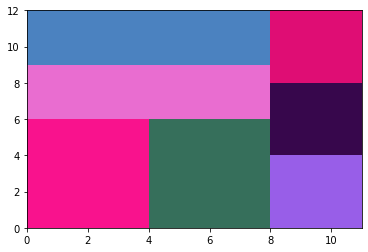

Solution: [[0, 9], [4, 0], [0, 0], [0, 6], [8, 8], [8, 4], [8, 0]]


In [178]:
path = f"instances/11x12.txt"
w_paper, h_paper, n, presents = read_input(path)
unordered_presents = list(presents)
presents, sorted_indices = order_presents(presents, method='area', reverse=True)
bl_corners = []
print(f"Paper dimensions: 11x12")
print(f"Presents dimensions: {presents}")
solutions = %minizinc -s pwp-v5
if solutions:
    show_solutions(w_paper, h_paper, n, presents, solutions)

Paper dimensions: 8x8
Presents dimensions: [[5, 5], [3, 5], [5, 3], [3, 3]]

Col_Stacking: true


Row_Stacking: true

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=48
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=74
mzn-stat: evaluatedReifiedConstraints=4
mzn-stat: evaluatedHalfReifiedConstraints=20
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.112933
mzn-stat-end
mzn-stat: initTime=0.007
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=76
mzn-stat: propagators=49
mzn-stat: propagations=148
mzn-stat: nodes=2
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end


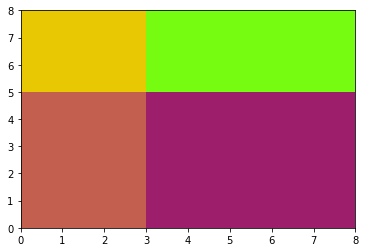

Solution: [[3, 0], [0, 0], [3, 5], [0, 5]]
Paper dimensions: 9x9
Presents dimensions: [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=85
mzn-stat: flatIntVars=65
mzn-stat: flatBoolConstraints=30
mzn-stat: flatIntConstraints=129
mzn-stat: evaluatedReifiedConstraints=5
mzn-stat: evaluatedHalfReifiedConstraints=70
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.114701
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=153
mzn-stat: propagators=129
mzn-stat: propagations=719
mzn-stat: nodes=10
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=6
mzn-stat-end


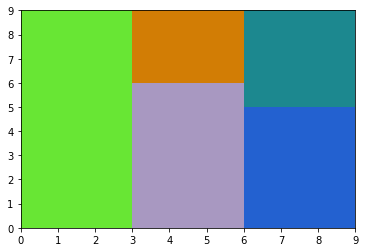

Solution: [[0, 0], [3, 0], [6, 0], [6, 5], [3, 6]]
Paper dimensions: 10x10
Presents dimensions: [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=88
mzn-stat: flatIntVars=78
mzn-stat: flatBoolConstraints=27
mzn-stat: flatIntConstraints=151
mzn-stat: evaluatedReifiedConstraints=6
mzn-stat: evaluatedHalfReifiedConstraints=76
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.115729
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=168
mzn-stat: propagators=146
mzn-stat: propagations=6608
mzn-stat: nodes=128
mzn-stat: failures=52
mzn-stat: restarts=0
mzn-stat: peakDepth=10
mzn-stat-end


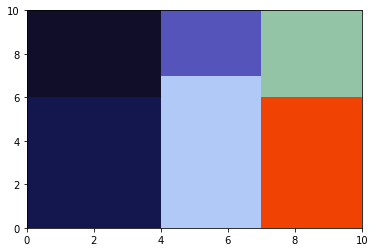

Solution: [[0, 0], [4, 0], [7, 0], [0, 6], [7, 6], [4, 7]]
Paper dimensions: 11x11
Presents dimensions: [[8, 4], [5, 4], [3, 6], [3, 5], [5, 3], [3, 4], [3, 3]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=91
mzn-stat: flatIntVars=84
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=167
mzn-stat: evaluatedReifiedConstraints=7
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.11924
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=175
mzn-stat: propagators=184
mzn-stat: propagations=9034
mzn-stat: nodes=110
mzn-stat: failures=51
mzn-stat: restarts=0
mzn-stat: peakDepth=8
mzn-stat-end


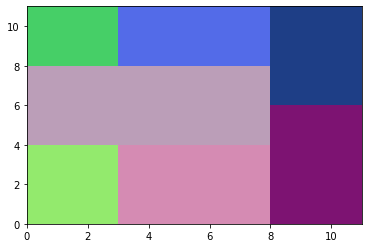

Solution: [[0, 4], [3, 0], [8, 0], [8, 6], [3, 8], [0, 0], [0, 8]]
Paper dimensions: 12x12
Presents dimensions: [[3, 9], [3, 8], [3, 7], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=120
mzn-stat: flatIntVars=96
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=206
mzn-stat: evaluatedReifiedConstraints=8
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.115779
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0.002
mzn-stat: solutions=1
mzn-stat: variables=216
mzn-stat: propagators=216
mzn-stat: propagations=15041
mzn-stat: nodes=220
mzn-stat: failures=105
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


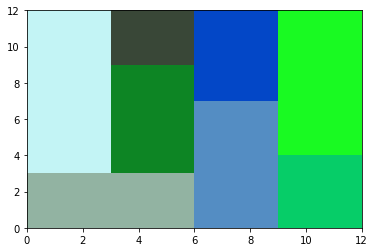

Solution: [[0, 3], [9, 4], [6, 0], [3, 3], [0, 0], [6, 7], [9, 0], [3, 9]]
Paper dimensions: 13x13
Presents dimensions: [[7, 6], [3, 8], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=153
mzn-stat: flatIntVars=108
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=249
mzn-stat: evaluatedReifiedConstraints=9
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.124312
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0.002
mzn-stat: solutions=1
mzn-stat: variables=261
mzn-stat: propagators=279
mzn-stat: propagations=16114
mzn-stat: nodes=192
mzn-stat: failures=90
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


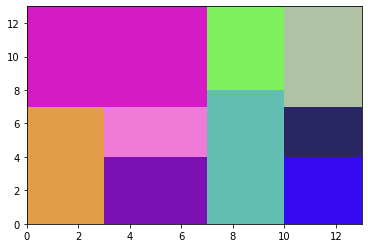

Solution: [[0, 7], [7, 0], [0, 0], [10, 7], [3, 0], [7, 8], [10, 0], [3, 4], [10, 4]]
Paper dimensions: 14x14
Presents dimensions: [[5, 10], [3, 9], [3, 8], [3, 7], [5, 4], [3, 6], [3, 5], [3, 4], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=235
mzn-stat: flatIntVars=118
mzn-stat: flatBoolConstraints=78
mzn-stat: flatIntConstraints=313
mzn-stat: evaluatedReifiedConstraints=9
mzn-stat: evaluatedHalfReifiedConstraints=205
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.141537
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=355
mzn-stat: propagators=341
mzn-stat: propagations=1141
mzn-stat: nodes=10
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=9
mzn-stat-end


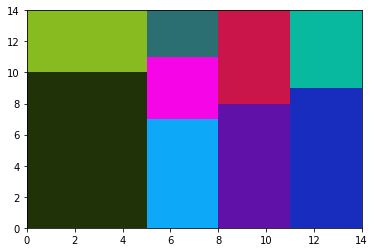

Solution: [[0, 0], [11, 0], [8, 0], [5, 0], [0, 10], [8, 8], [11, 9], [5, 7], [5, 11]]
Paper dimensions: 15x15
Presents dimensions: [[3, 15], [3, 12], [3, 9], [3, 8], [3, 7], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=117
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=293
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.124742
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=310
mzn-stat: propagators=304
mzn-stat: propagations=1094
mzn-stat: nodes=15
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


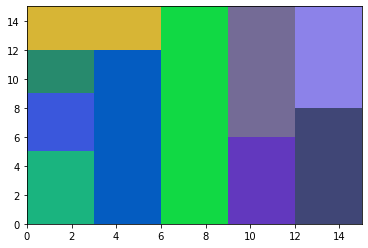

Solution: [[6, 0], [3, 0], [9, 6], [12, 0], [12, 8], [9, 0], [0, 12], [0, 0], [0, 5], [0, 9]]
Paper dimensions: 16x16
Presents dimensions: [[7, 9], [3, 12], [3, 10], [4, 7], [3, 8], [3, 7], [3, 6], [3, 5], [3, 4], [3, 3]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=120
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=296
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.129353
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=310
mzn-stat: propagators=317
mzn-stat: propagations=1312
mzn-stat: nodes=13
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


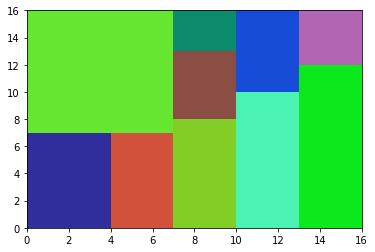

Solution: [[0, 7], [13, 0], [10, 0], [0, 0], [7, 0], [4, 0], [10, 10], [7, 8], [13, 12], [7, 13]]
Paper dimensions: 17x17
Presents dimensions: [[4, 14], [7, 6], [4, 8], [3, 9], [3, 8], [3, 7], [7, 3], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=276
mzn-stat: flatIntVars=144
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=402
mzn-stat: evaluatedReifiedConstraints=12
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.127781
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=420
mzn-stat: propagators=452
mzn-stat: propagations=6581
mzn-stat: nodes=56
mzn-stat: failures=20
mzn-stat: restarts=0
mzn-stat: peakDepth=20
mzn-stat-end


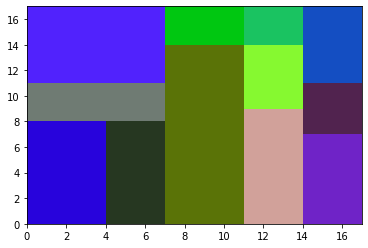

Solution: [[7, 0], [0, 11], [0, 0], [11, 0], [4, 0], [14, 0], [0, 8], [14, 11], [11, 9], [14, 7], [7, 14], [11, 14]]
Paper dimensions: 18x18
Presents dimensions: [[3, 11], [3, 10], [5, 6], [5, 5], [3, 8], [4, 6], [3, 7], [4, 5], [5, 4], [3, 6], [4, 4], [3, 5], [5, 3], [3, 4], [4, 3], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=584
mzn-stat: flatIntVars=199
mzn-stat: flatBoolConstraints=176
mzn-stat: flatIntConstraints=737
mzn-stat: evaluatedReifiedConstraints=16
mzn-stat: evaluatedHalfReifiedConstraints=540
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.146181
mzn-stat-end
mzn-stat: initTime=0.024
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=791
mzn-stat: propagators=733
mzn-stat: propagations=3627
mzn-stat: nodes=16
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


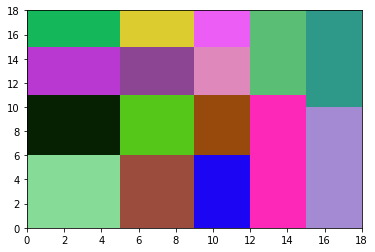

Solution: [[12, 0], [15, 0], [0, 0], [0, 6], [15, 10], [5, 0], [12, 11], [5, 6], [0, 11], [9, 0], [5, 11], [9, 6], [0, 15], [9, 11], [5, 15], [9, 15]]
Paper dimensions: 19x19
Presents dimensions: [[3, 19], [3, 13], [3, 11], [4, 8], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [3, 6], [3, 5], [3, 4], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=592
mzn-stat: flatIntVars=180
mzn-stat: flatBoolConstraints=201
mzn-stat: flatIntConstraints=685
mzn-stat: evaluatedReifiedConstraints=14
mzn-stat: evaluatedHalfReifiedConstraints=523
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.138711
mzn-stat-end
mzn-stat: initTime=0.022
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=778
mzn-stat: propagators=740
mzn-stat: propagations=2735
mzn-stat: nodes=18
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDepth=16
mzn-stat-end


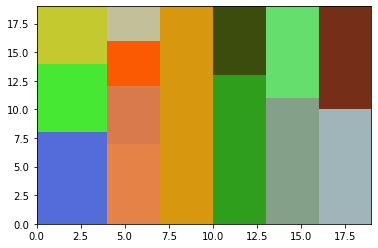

Solution: [[7, 0], [10, 0], [13, 0], [0, 0], [16, 0], [16, 10], [13, 11], [0, 8], [4, 0], [0, 14], [10, 13], [4, 7], [4, 12], [4, 16]]
Paper dimensions: 20x20
Presents dimensions: [[4, 17], [3, 17], [4, 11], [4, 9], [3, 11], [3, 10], [3, 9], [3, 8], [3, 7], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=582
mzn-stat: flatIntVars=188
mzn-stat: flatBoolConstraints=193
mzn-stat: flatIntConstraints=679
mzn-stat: evaluatedReifiedConstraints=14
mzn-stat: evaluatedHalfReifiedConstraints=517
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.137205
mzn-stat-end
mzn-stat: initTime=0.022
mzn-stat: solveTime=1.508
mzn-stat: solutions=1
mzn-stat: variables=770
mzn-stat: propagators=791
mzn-stat: propagations=7315536
mzn-stat: nodes=100867
mzn-stat: failures=50424
mzn-stat: restarts=0
mzn-stat: peakDepth=31
mzn-stat-end


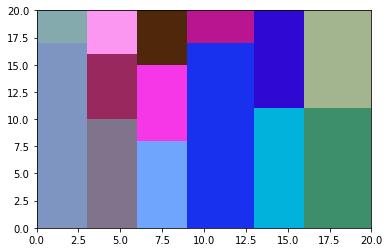

Solution: [[9, 0], [0, 0], [16, 0], [16, 11], [13, 0], [3, 0], [13, 11], [6, 0], [6, 8], [3, 10], [6, 15], [3, 16], [9, 17], [0, 17]]
Paper dimensions: 21x21
Presents dimensions: [[5, 15], [3, 18], [4, 11], [3, 14], [3, 10], [5, 6], [3, 9], [3, 8], [4, 6], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=607
mzn-stat: flatIntVars=193
mzn-stat: flatBoolConstraints=195
mzn-stat: flatIntConstraints=725
mzn-stat: evaluatedReifiedConstraints=15
mzn-stat: evaluatedHalfReifiedConstraints=547
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.143074
mzn-stat-end
mzn-stat: initTime=0.024
mzn-stat: solveTime=0.016
mzn-stat: solutions=1
mzn-stat: variables=805
mzn-stat: propagators=759
mzn-stat: propagations=133555
mzn-stat: nodes=1049
mzn-stat: failures=516
mzn-stat: restarts=0
mzn-stat: peakDepth=20
mzn-stat-end


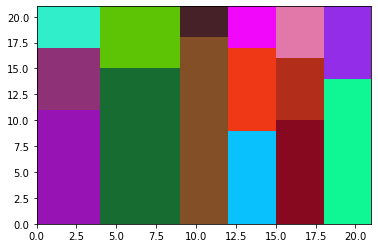

Solution: [[4, 0], [9, 0], [0, 0], [18, 0], [15, 0], [4, 15], [12, 0], [12, 9], [0, 11], [18, 14], [15, 10], [0, 17], [15, 16], [12, 17], [9, 18]]
Paper dimensions: 22x22
Presents dimensions: [[4, 19], [3, 22], [3, 14], [3, 13], [3, 12], [3, 11], [3, 10], [3, 9], [3, 8], [6, 4], [3, 7], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=496
mzn-stat: flatIntVars=189
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=659
mzn-stat: evaluatedReifiedConstraints=16
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.139776
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.071
mzn-stat: solutions=1
mzn-stat: variables=688
mzn-stat: propagators=707
mzn-stat: propagations=294292
mzn-stat: nodes=5755
mzn-stat: failures=2869
mzn-stat: restarts=0
mzn-stat: peakDepth=33
mzn-stat-end


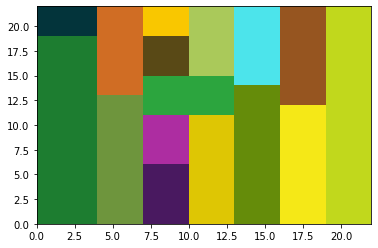

Solution: [[0, 0], [19, 0], [13, 0], [4, 0], [16, 0], [10, 0], [16, 12], [4, 13], [13, 14], [7, 11], [10, 15], [7, 0], [7, 6], [7, 15], [0, 19], [7, 19]]
Paper dimensions: 23x23
Presents dimensions: [[3, 20], [4, 12], [4, 11], [3, 14], [4, 10], [3, 12], [3, 11], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [3, 6], [6, 3], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Error in MiniZinc:

Col_Stacking: false


Row_Stacking: false

%%%mzn-stat: nSolutions=0

Paper dimensions: 24x24
Presents dimensions: [[5, 16], [3, 24], [3, 18], [4, 12], [3, 14], [5, 8], [3, 12], [3, 10], [3, 9], [3, 8], [3, 7], [4, 5], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]

Col_Stacking: true


Row_Stacking: false

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=880
mzn-stat: flatIntVars=228
mzn-stat: flatBoolConstraints=285
mzn-stat: flatIntConstraints=1007
mzn-stat: evaluatedReifiedConstraints=18
mzn-stat: evaluatedHalfReifiedConstraints=796
mzn-stat: me

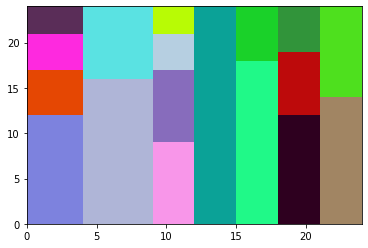

Solution: [[4, 0], [12, 0], [15, 0], [0, 0], [21, 0], [4, 16], [18, 0], [21, 14], [9, 0], [9, 9], [18, 12], [0, 12], [15, 18], [0, 17], [18, 19], [9, 17], [0, 21], [9, 21]]
Paper dimensions: 25x25
Presents dimensions: [[3, 25], [3, 19], [3, 18], [4, 13], [3, 17], [3, 14], [3, 13], [3, 11], [3, 10], [4, 7], [3, 9], [3, 8], [3, 7], [4, 5], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]


KeyboardInterrupt: 

In [181]:
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    path = f"instances/{i}x{i}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    unordered_presents = list(presents)
    presents, sorted_indices = order_presents(presents, method='area', reverse=True)
    bl_corners = []
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    solutions = %minizinc -s pwp-v5
    if solutions:
        show_solutions(w_paper, h_paper, n, presents, solutions)

### First model 

In [88]:
%%mzn_model pwp-v1
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of var 0..max(w_paper, h_paper) - 1: bl_corners;
array[1..n, 1..2] of int: presents;
constraint forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] <= w_paper);
constraint forall(i in 1..n) (bl_corners[i, 2] + presents[i, 2] <= h_paper);
constraint forall(i, j in 1..n where j > i) (
    max(bl_corners[i, 1], bl_corners[j, 1]) >= min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) \/
    max(bl_corners[i, 2], bl_corners[j, 2]) >= min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2])
);
solve satisfy;

### Second model

In [93]:
%%mzn_model pwp-v2
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

function var int: coord_to_value(var int: x, var int: y) = x + y * (max_dim + 1);
function var int: x_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) - max(bl_corners[i, 1], bl_corners[j, 1]));
function var int: y_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2]) - max(bl_corners[i, 2], bl_corners[j, 2]));
function var int: overlap_area(int: i, int: j) = x_overlap(i, j) * y_overlap(i, j);

array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n] of var 0..max_dim * max_dim: bl_corners_values;

predicate values_channeling(int: i) = 
    forall(i in 1..n) (bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]));
constraint forall(i in 1..n) (values_channeling(i));

constraint alldifferent(bl_corners_values);
constraint count_eq(bl_corners_values, 0, 1);
constraint forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] <= w_paper);
constraint forall(i in 1..n) (bl_corners[i, 2] + presents[i, 2] <= h_paper);
constraint forall(i, j in 1..n where j > i) (overlap_area(i, j) == 0);
solve satisfy;

### Third model

In [97]:
%%mzn_model pwp-v3
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
array[1..n, 1..2] of 1..max_dim: presents;
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

function var int: coord_to_value(var int: x, var int: y) = x + y * (max_dim + 1);

array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..max_dim * max_dim: bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

predicate values_channeling(int: i) = 
    forall(i in 1..n) (bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]));
constraint forall(i in 1..n) (values_channeling(i));

predicate bl_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] == bl_corners_xs[i] /\ bl_corners[i, 2] == bl_corners_ys[i]);
constraint forall(i in 1..n) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] == tr_corners[i, 1] /\ bl_corners[i, 2] + presents[i, 2] == tr_corners[i, 2]);
constraint forall(i in 1..n) (tr_corners_channeling(i));

constraint alldifferent(bl_corners_values);
constraint count_eq(bl_corners_values, 0, 1);
constraint diffn_k(bl_corners, presents);
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);
solve satisfy;

### Fourth model

In [127]:
%%mzn_model pwp-v4
include "globals.mzn";

%Input values
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
array[ns, 1..2] of int: presents;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..(w_paper * h_paper) - 1: bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };

function int: other_axis(int: axis) = if axis == 1 then 2 elseif axis == 2 then 1 else 0 endif;

% Constraints
predicate bl_corners_channeling(int: i) = bl_corners_xs[i] == bl_corners[i, 1] /\ bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Reduce presents domains
constraint forall(i in ns) (bl_corners_xs[i] <= w_paper - presents_xs[i] /\ bl_corners_ys[i] <= h_paper - presents_ys[i]);
constraint forall(i in ns) (tr_corners[i, 1] >= presents_xs[i] /\ tr_corners[i, 2] >= presents_ys[i]);

%Presents in the same column ordered by width
%constraint forall(i, j in ns where j > i) ( (bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j]) -> bl_corners_ys[i] > bl_corners_ys[j]);

%2 presents sum to h_paper or w_paper
%constraint forall(i, j in ns where j > i)(presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j] == h_paper -> bl_corners_ys[j] = presents_ys[i] /\ bl_corners_ys[i] = 0);
%constraint forall(i, j in ns where j > i)(presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j] == w_paper -> bl_corners_xs[j] = presents_xs[i] /\ bl_corners_xs[i] = 0);

%First present in the lower left quadrant
%constraint bl_corners_xs[1] <= w_paper / 2 /\ bl_corners_ys[1] <= h_paper / 2;

%Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) <= total_paper_area;
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) == total_presents_area;

%All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

%One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

%Presents cannot overlap
constraint diffn_k(bl_corners, presents);

constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);


%constraint bl_corners_xs[1] == 0 /\ bl_corners_ys[1] == 0;
%constraint bl_corners_xs[max_present_ind]<=(w_paper - presents_xs[max_present_ind])/2 /\ bl_corners_ys[max_present_ind]<=(h_paper - presents_ys[max_present_ind])/2;

%solve :: int_search(bl_corners_values, dom_w_deg, indomain_min) :: restart_luby(100) satisfy;
%solve minimize sum(bl_corners_values);
solve satisfy;

### Fifth model (with rotation)

In [180]:
%%mzn_model pwp-v5
include "globals.mzn";


%Input values
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
    
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
set of int: presents_ys_values = distinct_values(presents_ys);
    
array[ns, 1..2] of int: presents;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];

% Variables
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_values];
array[1..card(presents_ys_values)] of set of ns: presents_group_ys = [group_presents(i, 2) | i in presents_ys_values];
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns, 1..4] of var 0..coord_to_value(w_paper, h_paper): corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);

function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };

function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};

function int: other_axis(int: axis) = if axis == 1 then 2 elseif axis == 2 then 1 else 0 endif;

predicate is_col_stacking_feasible() = forall(i in 1..card(presents_xs_values))(sum([presents_ys[j] | j in presents_group_xs[i]])>=h_paper);

predicate is_row_stacking_feasible() = forall(i in 1..card(presents_ys_values))(sum([presents_xs[j] | j in presents_group_ys[i]])>=w_paper);

% Constraints
predicate stack_cols(int: i) = let { 
    int: n_presents= card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = sum(weights) div h_paper;
    array[1..n_presents] of var 1..columns: bins 
    } in bin_packing(h_paper, bins, weights) /\ forall(h,l in 1..n_presents where l>h) ((bins[h]==bins[l]) -> (
        bl_corners_xs[indexes[h]]==bl_corners_xs[indexes[l]] /\ 
        bl_corners_ys[indexes[l]]>=bl_corners_ys[indexes[h]] + presents_ys[indexes[h]]));

predicate stack_rows(int: i) = let { 
    int: n_presents= card(presents_group_ys[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_ys[i]];
    array[1..n_presents] of 1..w_paper: weights = [presents_xs[j] | j in indexes];
    int: columns = sum(weights) div w_paper;
    array[1..n_presents] of var 1..columns: bins 
    } in bin_packing(w_paper, bins, weights) /\ forall(h,l in 1..n_presents where l>h) ((bins[h]==bins[l]) -> (
        bl_corners_ys[indexes[h]]==bl_corners_ys[indexes[l]] /\ 
        bl_corners_xs[indexes[l]]>=bl_corners_xs[indexes[h]] + presents_xs[indexes[h]]));

constraint trace("\nCol_Stacking: "++show(is_col_stacking_feasible())++"\n\n",is_col_stacking_feasible()) -> forall(i in 1..card(presents_xs_values)) (stack_cols(i));
constraint trace("\nRow_Stacking: "++show(is_row_stacking_feasible())++"\n\n",is_row_stacking_feasible() /\ not is_col_stacking_feasible()) -> forall(i in 1..card(presents_ys_values)) (stack_rows(i));


% Channeling constraints
predicate corners_values_channeling(int: i) = 
    corners_values[i,1] == bl_corners_values[i] /\ 
    corners_values[i,2] == coord_to_value(bl_corners_xs[i] + presents_xs[i], bl_corners_ys[i]) /\
    corners_values[i,3] == coord_to_value(tr_corners[i,1], tr_corners[i,2]) /\
    corners_values[i,4] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i] + presents_ys[i]);
constraint forall(i in ns) (corners_values_channeling(i));

predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Reduce presents domains
constraint forall(i in ns) (bl_corners_xs[i] <= w_paper - presents_xs[i] /\ bl_corners_ys[i] <= h_paper - presents_ys[i]);
constraint forall(i in ns) (tr_corners[i,1] >= presents_xs[i] /\ tr_corners[i,2] >= presents_ys[i]);

% Corners anchor points
%constraint forall(i in ns) (exists(j in ns where j != i) (exists (k in 2..4) (corners_values[i, 1] == corners_values[j, k])));

%Presents in the same column ordered by width
%constraint forall(i, j in ns where j > i) ( (bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j]) -> bl_corners_ys[i] > bl_corners_ys[j]);

%2 presents sum to h_paper or w_paper
%constraint forall(i,j in ns where j > i)(presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j]==h_paper -> bl_corners_ys[j]=presents_ys[i] /\ bl_corners_ys[i] = 0);
%constraint forall(i,j in ns where j > i)(presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j]==w_paper -> bl_corners_xs[j]=presents_xs[i] /\ bl_corners_xs[i] = 0);

%First present in the lower left quadrant
%constraint bl_corners_xs[1] <= w_paper / 2 /\ bl_corners_ys[1] <= h_paper / 2;

%Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) <= total_paper_area;
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) == total_presents_area;

%All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

%One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

%Presents cannot overlap
constraint diffn_k(bl_corners, presents);

constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);


%constraint bl_corners_xs[1] == 0 /\ bl_corners_ys[1] == 0;
%constraint bl_corners_xs[max_present_ind]<=(w_paper - presents_xs[max_present_ind])/2 /\ bl_corners_ys[max_present_ind]<=(h_paper - presents_ys[max_present_ind])/2;

%solve :: int_search(bl_corners_values, dom_w_deg, indomain_min) :: restart_luby(100) satisfy;
%solve minimize sum(bl_corners_values);
solve satisfy;

## SMT model

In [ ]:
def z3max(x,y):
    return If(x > y, x, y)

def z3min(x,y):
    return If(x < y, x, y)

bl_corners= [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n) ]
domain = [And(0<=bl_corners[i][0],bl_corners[i][0]<w_paper,0<=bl_corners[i][1],bl_corners[i][1]< h_paper) for i in range(n)]
overflow = [And(bl_corners[i][0]+presents[i][0]<=w_paper,bl_corners[i][1]+presents[i][1]<=h_paper) for i in range(n)]
pp(bl_corners)
intersection = [ And(
    Or(
        z3max(bl_corners[i][0],bl_corners[j][0])>=z3min(bl_corners[i][0]+presents[i][0],bl_corners[j][0]+presents[j][0]),
        z3max(bl_corners[i][1],bl_corners[j][1])>=z3min(bl_corners[i][1]+presents[i][1],bl_corners[j][1]+presents[j][1])
     )) for i in range(n) for j in range(i+1,n) ]

In [ ]:
%%time
s = Solver()
s.add(domain + overflow + intersection)
s.check()
sol = s.model()
solution=[[sol[bl_corners[i][0]], sol[bl_corners[i][1]]] for i in range(n)]
solution